In [1]:
# segment video into times when person is walking away from the camera, toward the camera, and turning 


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal as sig 
import os 

In [3]:
# import functions from sandbox src 
from filtering_funs import filter_landmark_single_axis

[NbConvertApp] Converting notebook filtering_funs.ipynb to script
[NbConvertApp] Writing 1299 bytes to filtering_funs.py


In [4]:
# remove this after confirming code works 
mp_all_filepath = r'..\..\temp\test_sandbox_pipeline_outputs\002_frames_to_time\DS_HC_gait_vertical_left_mediapipe_all.csv'
yolo_filepath = r'..\..\temp\test_sandbox_pipeline_outputs\002_frames_to_time\DS_HC_gait_vertical_left_yolo.csv'

mp_all_df = pd.read_csv(mp_all_filepath, index_col = 0)
yolo_df = pd.read_csv(yolo_filepath, index_col = 0)

yolo_df.head()

# filtering vars 
fps = 60 # fps of video (from previous script)
cutoff = 0.4  # Desired cutoff frequency of the filter in Hz
order = 1  # Order of the filter (higher means sharper cutoff)

In [23]:
# use hip z position to ID start, stop, and midpoint of turns in vertical videos 

# filter right and left hip z pose data 
[hip_r_mp_z, hip_r_mp_z_filt] = filter_landmark_single_axis(df = mp_all_df, 
                                                              landmark = 'right_hip', 
                                                              axis_to_filter = 'Z_pose', 
                                                              video_fps = fps, 
                                                              cutoff_hz = cutoff, 
                                                              filter_order = order)

[hip_l_mp_z, hip_l_mp_z_filt] = filter_landmark_single_axis(df = mp_all_df, 
                                                              landmark = 'left_hip', 
                                                              axis_to_filter = 'Z_pose', 
                                                              video_fps = fps, 
                                                              cutoff_hz = cutoff, 
                                                              filter_order = order)
# distance between l and r z 
hip_z_diff_mp_filt = hip_l_mp_z_filt - hip_r_mp_z_filt
hip_z_diff_mp_filt = pd.Series(hip_z_diff_mp_filt).rolling(window=15, min_periods=1).mean()

# find max and min of hip distance filtered 
    # max and min = frame of midpoint of turn 
hip_z_diff_mp_filt_peak_frames, _ = sig.find_peaks(hip_z_diff_mp_filt, distance = 200, prominence = (0.2, None))
hip_z_diff_mp_filt_valley_frames, _ = sig.find_peaks(-hip_z_diff_mp_filt, distance = 200, prominence = (0.2, None))

# merge together peaks and valleys of hip z diff df -> frames of each turn, ordered 
hip_z_diff_mp_filt_turn_midpoints = np.concatenate((hip_z_diff_mp_filt_peak_frames, hip_z_diff_mp_filt_valley_frames), axis = None)
hip_z_diff_mp_filt_turn_midpoints = np.sort(hip_z_diff_mp_filt_turn_midpoints)

# rate of change of z hip distance 
diff_hip_z_diff_mp_filt = np.diff(hip_z_diff_mp_filt)
diff_hip_z_diff_mp_filt = np.insert(diff_hip_z_diff_mp_filt, 0, np.nan)
diff_hip_z_diff_mp_filt = pd.Series(diff_hip_z_diff_mp_filt)

# max and min of rate of change of hip z distance 
# max and min = start and stop of turn 
    # depending on R or L turn and close or far from camera, max could be start and min stop or vice versa 
diff_hip_z_diff_mp_filt_peak_frames, _ = sig.find_peaks(diff_hip_z_diff_mp_filt, distance = 200, prominence = (0.005, None))
diff_hip_z_diff_mp_filt_valley_frames, _ = sig.find_peaks(-diff_hip_z_diff_mp_filt, distance = 200, prominence = (0.005, None))

# create data frame with start, midpoint, and stop frame for each turn
turn_df = pd.DataFrame(index=range(len(hip_z_diff_mp_filt_turn_midpoints)), columns = ['turn_num', 
                                                                                       'turn_start_frame', 
                                                                                       'turn_midpoint', 
                                                                                       'turn_stop_frame', 
                                                                                       'frames_per_turn', 
                                                                                       'seconds_per_turn'])

for i_turns, turn_midpoint_frame in enumerate(hip_z_diff_mp_filt_turn_midpoints): 
    turn_df.iloc[i_turns, 0] = i_turns
    turn_df.iloc[i_turns, 2] = turn_midpoint_frame

    # if the first peak comes before the first valley of hip distance rate of change, peak = turn start and valley = turn stop 
    if diff_hip_z_diff_mp_filt_peak_frames[i_turns] < diff_hip_z_diff_mp_filt_valley_frames[i_turns]:
        turn_df.iloc[i_turns, 1] = diff_hip_z_diff_mp_filt_peak_frames[i_turns] # start 
        turn_df.iloc[i_turns, 3] = diff_hip_z_diff_mp_filt_valley_frames[i_turns] # stop 
    elif diff_hip_z_diff_mp_filt_valley_frames[i_turns] < diff_hip_z_diff_mp_filt_peak_frames[i_turns]:
        turn_df.iloc[i_turns, 1] = diff_hip_z_diff_mp_filt_valley_frames[i_turns] # start 
        turn_df.iloc[i_turns, 3] = diff_hip_z_diff_mp_filt_peak_frames[i_turns] # stop 
        
# frames per turn 
turn_df['frames_per_turn'] = turn_df['turn_stop_frame'] - turn_df['turn_start_frame']

# seconds per turn 
turn_df['seconds_per_turn'] = (turn_df['frames_per_turn'] / fps)

,turn_num,turn_start_frame,turn_midpoint,turn_stop_frame,frames_per_turn,seconds_per_turn
0,0,303,330,361,58,0.966667
1,1,645,675,718,73,1.216667
2,2,982,1004,1028,46,0.766667
3,3,1314,1338,1374,60,1.0
4,4,1627,1648,1667,40,0.666667


In [7]:
# Use distance between shoulders in pixels (yolo) to determine direction subject is moving 
    # shoulder width increasing = walking toward camera  
    #  shoulder width decreasing = walking away from camera
    # use start and stop of turns from hip z distance to ID walking times 

# create one df for r shoulder, one for l 
shoulder_r_yolo_df = yolo_df.loc[(yolo_df['label'] == 'right_shoulder')]
shoulder_r_yolo_df.index = shoulder_r_yolo_df['frame']

shoulder_l_yolo_df = yolo_df.loc[(yolo_df['label'] == 'left_shoulder')]
shoulder_l_yolo_df.index = shoulder_l_yolo_df['frame']

# shoulder width 
shoulder_width_yolo = abs(shoulder_r_yolo_df['X'] - shoulder_l_yolo_df['X'])
shoulder_width_yolo_smooth = pd.Series(shoulder_width_yolo).rolling(window=15, min_periods=1).mean()

In [ ]:
## from r - l hip position 
    # find max and min of r and l turn 
    # idea 1 
        # work backwards and forwards from local max and local min - "bound" it by turn start and stop..?

    # idea 2
        # start of turn - difference greater than cutoff? diff of differnece > ?
        # end of turn - difference less than cutoff? diff of differnece > ?

# see notebook and phone photo for joining info from shoulders and hips 

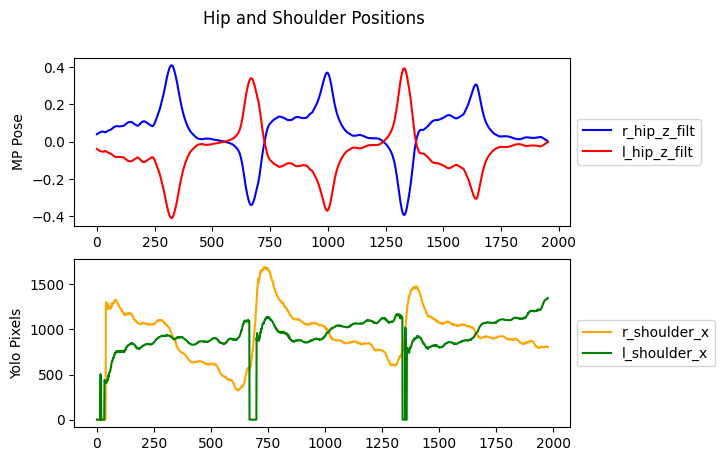

In [13]:
# plots of hip and shoulder positions 

# set plot with two subplots 
fig1, (ax1, ax2) = plt.subplots(2)
fig1.suptitle('Hip and Shoulder Positions')

# subplot 1 - mp z for each hip 
ax1.plot(hip_r_mp_z_filt, label = 'r_hip_z_filt', color = 'blue')
ax1.plot(hip_l_mp_z_filt, label = 'l_hip_z_filt', color = 'red')
ax1.set_ylabel('MP Pose')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# subplot 2 - yolo x for each shoulder 
ax2.plot(shoulder_r_yolo_df['frame'], shoulder_r_yolo_df['X'], label = 'r_shoulder_x', color = 'orange')
ax2.plot(shoulder_r_yolo_df['frame'], shoulder_l_yolo_df['X'], label = 'l_shoulder_x', color = 'green')
ax2.set_ylabel('Yolo Pixels')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

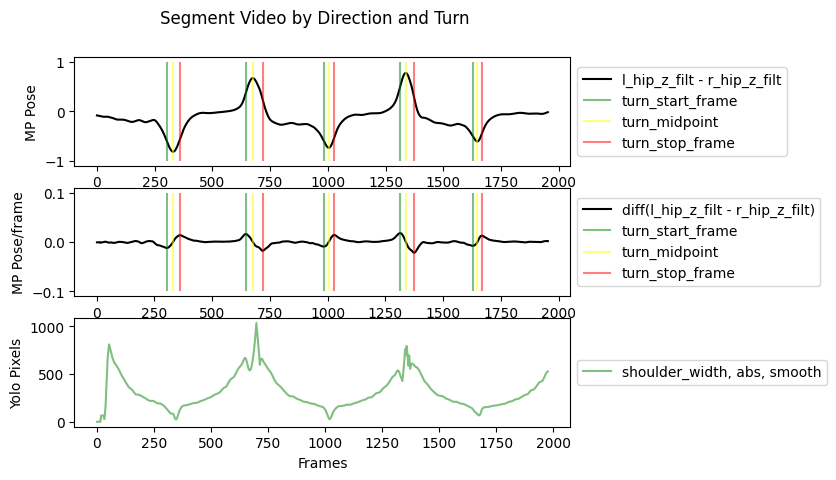

In [17]:
# plot 2 
# set plot with two subplots 
fig2, (ax1, ax2, ax3) = plt.subplots(3)
fig2.suptitle('Segment Video by Direction and Turn')

# subplot 1 - distance between right and left hip, use peaks and mins as turns 

ax1.plot(hip_z_diff_mp_filt, label = 'l_hip_z_filt - r_hip_z_filt', color = 'black')
ax1.vlines(x=turn_df['turn_start_frame'], ymin = -1, ymax = 1, color = 'green', alpha = 0.5, label = 'turn_start_frame')
ax1.vlines(x=turn_df['turn_midpoint'], ymin = -1, ymax = 1, color = 'yellow', alpha = 0.5, label = 'turn_midpoint')
ax1.vlines(x=turn_df['turn_stop_frame'], ymin = -1, ymax = 1, color = 'red', alpha = 0.5, label = 'turn_stop_frame')    
ax1.set_ylabel('MP Pose')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# subplot 2 - change in hip distance 
ax2.plot(diff_hip_z_diff_mp_filt, label = 'diff(l_hip_z_filt - r_hip_z_filt)', color = 'black')
ax2.vlines(x=turn_df['turn_start_frame'], ymin = -.1, ymax = .1, color = 'green', alpha = 0.5, label = 'turn_start_frame')
ax2.vlines(x=turn_df['turn_midpoint'], ymin = -.1, ymax = .1, color = 'yellow', alpha = 0.5, label = 'turn_midpoint')
ax2.vlines(x=turn_df['turn_stop_frame'], ymin = -.1, ymax = .1, color = 'red', alpha = 0.5, label = 'turn_stop_frame')    
ax2.set_ylabel('MP Pose/frame')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# sublot 3 - yolo shoulder width 
ax3.plot(shoulder_width_yolo_smooth, label = "shoulder_width, abs, smooth", color = 'green', linestyle = '-', alpha = 0.5)
ax3.set_xlabel('Frames')
ax3.set_ylabel('Yolo Pixels')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# outputs 
    # save plot 
    # add column - away 1, turn 1, toward 1, away 2 
    # save df (and as .csv) with frames at which events occur (ie - columns: away_1_start, away_1_stop, turn_1 start, turn_1_stop, etc) 
    # save time of each walk, time per turn, etc 

# save number of turns 
data = {'number_of_turns':[len(hip_z_diff_mp_filt_turn_midpoints)]}
num_turns = pd.DataFrame(data)
# save as .csv 

# save turn_df as .csv 